In [1]:
%load_ext autoreload
%autoreload 2

In [15]:

from mt.ds import build_dataset


ds = build_dataset(
    name='wmt14',
    source='de',
    target='en',
    is_encoder_decoder=False,
)



Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
import numpy as np

# Assuming ds.dataset is loaded as shown earlier
tok = ds.get_tokenizer()
dataset = ds.dataset


# Define a function to tokenize text and calculate lengths
def tokenize_and_length(examples):
    # Tokenize the text
    examples['de'] = [sample['de'] for sample in examples['translation']] 
    examples['en'] = [sample['en'] for sample in examples['translation']]

    
    source_encodings = tok(examples["de"])
    target_encodings = tok(examples["en"])
    examples["source_length"] = [
        len(sample) for sample in source_encodings["input_ids"]
    ]
    examples["target_length"] = [
        len(sample) for sample in target_encodings["input_ids"]
    ]
    return examples


# Apply the function to the 'train' split
dataset = dataset.map(tokenize_and_length, batched=True)



Map:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (12087 > 4096). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3003 [00:00<?, ? examples/s]

In [17]:
source_len = [lens for lens in dataset["train"]["source_length"]]
target_len = [lens for lens in dataset["train"]["target_length"]]

total_lengths = [x + y for x, y in zip(source_len, target_len)]

# Calculate statistics
mean_length = np.mean(total_lengths)
max_length = np.max(total_lengths)
std_deviation = np.std(total_lengths)

print("Mean of total lengths:", mean_length)
print("Maximum of total lengths:", max_length)
print("Standard deviation of total lengths:", std_deviation)

Mean of total lengths: 62.13133671266206
Maximum of total lengths: 17017
Standard deviation of total lengths: 45.6360703517223


In [13]:
source_len = [lens for lens in dataset["validation"]["source_length"]]
target_len = [lens for lens in dataset["validation"]["target_length"]]

total_lengths = [x + y for x, y in zip(source_len, target_len)]

# Calculate statistics
mean_length = np.mean(total_lengths)
max_length = np.max(total_lengths)
std_deviation = np.std(total_lengths)

print("Mean of total lengths:", mean_length)
print("Maximum of total lengths:", max_length)
print("Standard deviation of total lengths:", std_deviation)

Mean of total lengths: 65.32516258129064
Maximum of total lengths: 319
Standard deviation of total lengths: 35.74354658847442


In [14]:
source_len = [lens for lens in dataset["test"]["source_length"]]
target_len = [lens for lens in dataset["test"]["target_length"]]

total_lengths = [x + y for x, y in zip(source_len, target_len)]

# Calculate statistics
mean_length = np.mean(total_lengths)
max_length = np.max(total_lengths)
std_deviation = np.std(total_lengths)

print("Mean of total lengths:", mean_length)
print("Maximum of total lengths:", max_length)
print("Standard deviation of total lengths:", std_deviation)

Mean of total lengths: 61.596298149074535
Maximum of total lengths: 440
Standard deviation of total lengths: 34.649717282497846


In [7]:
from models.mamba import MambaMT  

model = MambaMT(
    tokenizer=tokenizer,
    vocab_size=tokenizer.vocab_size,
    precision="bf16-mixed",
    # dropout=0,
    **MambaMT.configs["default"]
)
# print nr of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

77011890


In [8]:
model = model.to("cuda")

In [20]:
sample = ds.dataset["test"]['translation'][0]
template = f"{sample['de']}{tokenizer.sep_token}{sample['en']}" 
tok_sample = tokenizer(template, return_tensors='pt')["input_ids"]
tok_sample = tok_sample.to('cuda')

In [21]:
tok_sample

tensor([[ 1127,  3401,  1133,    15,   737,   860,  1785,    15,  4708,  9689,
          3290,   456,  2320,   621,  2344,    16,    58, 25488,  3186,   432,
          5323,  4108, 21088,    16, 26001,   478,  2794,   404,     5,   650,
            17,     2, 29064,   311,   861,  1603,   792,   522,  1785,    15,
          9689,  3290,   456,  2320,   224, 10831,   265,  1449,  4143,   224,
          1321,   280, 31589,  4143,    17,     1]], device='cuda:0')

In [59]:
import torch
from mamba_ssm.utils.generation import InferenceParams

cache = model.model.allocate_inference_cache(
        batch_size=1,
        max_seqlen=128,
)


inf_params = InferenceParams(
    max_seqlen=128,
    max_batch_size=1,
    key_value_memory_dict=cache,
    use_xai=True,
    seqlen_offset=1
)

with torch.inference_mode():

    for i in range(tok_sample.size(1)):
        out = model.model.forward(
            tok_sample[:, i:i+1],
            inference_params=inf_params,
        )
        inf_params.seqlen_offset += 1
    
out

torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Size([1, 16])
torch.Size([1, 1220, 16]) torch.Si

CausalLMOutput(logits=tensor([[[-0.2443,  5.6659, -0.3555,  ...,  0.2440, -0.3579,  0.8280]]],
       device='cuda:0'))

In [53]:
inf_params.xai[0]["a_bar"][0].shape, inf_params.xai[0]["b_bar"][
    0
].shape

(torch.Size([1, 1220, 16]), torch.Size([1, 1220, 16]), torch.Size([1, 16]))

In [65]:
b_0, c_0 = inf_params.xai[0]["b_bar"][0], inf_params.xai[0]["c"][0]

b_0.shape, c_0.shape

(torch.Size([1, 1220, 16]), torch.Size([1, 16]))

In [66]:
a = torch.stack(inf_params.xai[0]["a_bar"], dim=1)
a.shape

torch.Size([1, 56, 1220, 16])

In [80]:
b = torch.stack(inf_params.xai[0]["b_bar"], dim=1)
c = torch.stack(inf_params.xai[0]["c"], dim=1)

In [81]:
b.shape, c.shape

(torch.Size([1, 56, 1220, 16]), torch.Size([1, 56, 16]))

In [84]:
b

tensor([[[[-1.5080e-03,  7.1302e-05, -6.4970e-04,  ...,  5.1986e-04,
            1.1468e-03,  3.3800e-04],
          [-1.5483e-03,  7.3210e-05, -6.6708e-04,  ...,  5.3377e-04,
            1.1774e-03,  3.4704e-04],
          [-1.6585e-03,  7.8418e-05, -7.1454e-04,  ...,  5.7175e-04,
            1.2612e-03,  3.7173e-04],
          ...,
          [-1.1041e-02,  5.2206e-04, -4.7569e-03,  ...,  3.8063e-03,
            8.3963e-03,  2.4747e-03],
          [-1.2949e-02,  6.1225e-04, -5.5788e-03,  ...,  4.4639e-03,
            9.8469e-03,  2.9023e-03],
          [-4.7815e-03,  2.2609e-04, -2.0601e-03,  ...,  1.6484e-03,
            3.6361e-03,  1.0717e-03]],

         [[-1.1052e-03, -1.2113e-04,  5.1838e-05,  ...,  5.8478e-04,
            1.5860e-03,  4.5976e-04],
          [-1.0813e-03, -1.1852e-04,  5.0718e-05,  ...,  5.7214e-04,
            1.5517e-03,  4.4983e-04],
          [-1.2590e-03, -1.3800e-04,  5.9055e-05,  ...,  6.6619e-04,
            1.8068e-03,  5.2378e-04],
          ...,
     

In [110]:
a.shape, b.shape, c.shape

(torch.Size([1, 56, 1220, 16]),
 torch.Size([1, 56, 1220, 16]),
 torch.Size([1, 56, 16]))

In [111]:
import torch

# Assuming a, b, c are already defined with the given shapes and are on the CUDA device

# Initialize alphas tensor on the GPU
alphas = torch.zeros((56, 56), device="cuda")

# Dictionary to store intermediate products to avoid recomputation
prods = {}

for i in range(56):
    for j in range(i + 1):  # Ensure j is always less than or equal to i
        # Check if we've already computed the product for this range
        if (j, i) not in prods:
            # If not, compute it by accumulating the product
            prod = torch.ones(
                (1, 16), device="cuda"
            )  # Starting with identity for the product
            for k in range(j, i):
                prod = torch.einsum("bnm,bmk->bnk", prod, a[:, k, ...])
            prods[(j, i)] = prod
        else:
            # If already computed, retrieve it from the dictionary
            prod = prods[(j, i)]

        # Compute the alpha value using einsum to match dimensions
        alphas[i, j] = torch.einsum(
            "bn,bn,bn->", c[:, i, :], prod.squeeze(), b[:, j, :]
        )

# alphas should now contain the correct values according to the given equation
print(alphas)

ValueError: Einstein sum subscript 'bn' does not contain the correct number of indices for operand 1.

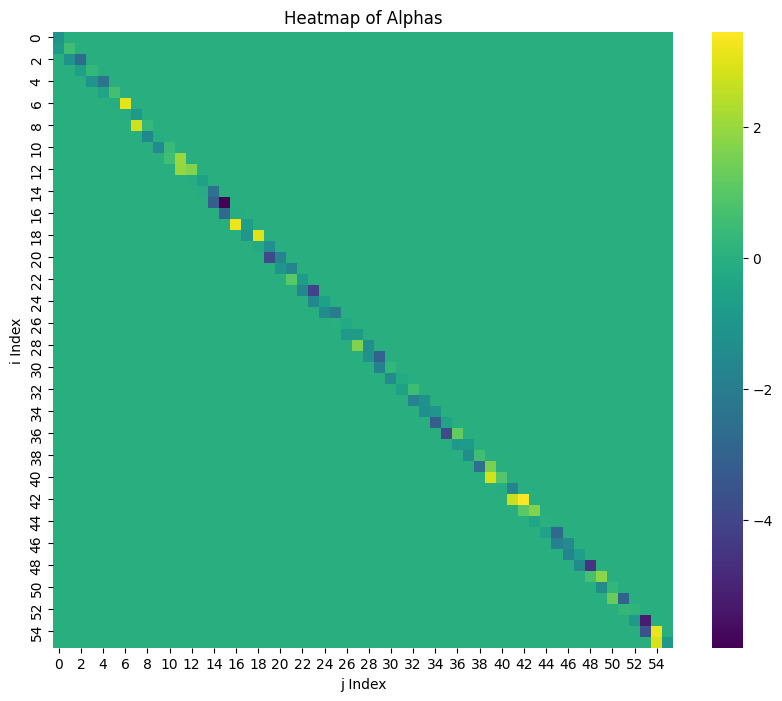

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'alphas' is computed as per the logic you've intended
plt.figure(figsize=(10, 8))
sns.heatmap(alphas.cpu().numpy(), annot=False, cmap="viridis")
plt.title("Heatmap of Alphas")
plt.xlabel("j Index")
plt.ylabel("i Index")
plt.show()

In [79]:
import torch

# Assuming 'a' is defined and has the appropriate size and number of dimensions
result = torch.einsum("bdn,bdn -> ", a[:, 1, ...], a[:, 2, ...])
print(result)  # This will print the scalar result of the contraction

tensor(14898.1191, device='cuda:0')


In [ ]:
from einops import einsum 

einsum()

In [13]:
import torch
model = model.to(torch.bfloat16)